<a href="https://colab.research.google.com/github/j-kohmaru-gunma/AraMaNet/blob/main/AramaLibrary_v2_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
from sklearn.datasets import make_swiss_roll
import scipy.sparse as sp
import time
import sys

class AramaNet:

    def __init__(self, input_dim=2,init_v=16, max_v=1024,lr=0.2 , depth=32, threshold=0.01):

        self.max_v = max_v
        self._in = np.zeros(input_dim, dtype=np.uint8) #入力値保存用
        self.lr = lr # 学習率
        self.input_dim = input_dim #　入力次元
        self.vertex = VertexUnit(input_dim, init_v, max_v) #頂点層
        self.simplex = [SimplexUnit(self.vertex)] #単体層

        self.train_log = []

        self.out_threshold = threshold

        # スコアと閾値の対応表
        self.threshold = np.arange(1, 0, -1/256)
        print(self.threshold)

    def forward(self, x, update=False):

        self._in = x.copy()
        layer = 0

        # 入力がnp.int8かチェック
        if not (isinstance(x, np.ndarray) and x.dtype == np.uint8 and x.ndim == 1):
            raise ValueError("不正な値です。入力はnp.int8の一次元配列にしてください")

        # 頂点層推論
        x = self.vertex.forward(x)
        idx = np.argmin(x)
        vertex = idx.reshape(1,-1)
        output = x

        # 再構成誤差
        recon = self.vertex.centers[idx,:-2]
        error = x[idx] / np.sqrt(self.input_dim) / 255

        # 単体層推論ループ
        for s in self.simplex:

            # 再構成誤差が閾値未満であれば途中出力
            if self.out_threshold > error: break;

            #ノードがない場合キャンセル
            if s.nodes.size == 0: break;

            # 推論
            x = s.forward(x)

            # 再構成
            # (テスト段階なので全ノードを用いた再構成、今後ノードを絞る機構を入れる予定）
            v = s.nodes[:,s.k:-2]
            r = self.reconstruct(v)

            # 再構成誤差を計算
            d = r - self._in
            d[r < self._in] = 255 - d[r < self._in] + 1
            e = np.linalg.norm(d,axis=1) / np.sqrt(self.input_dim) / 255

            # 前層と比較して再構成精度の改善が見られなければ、途中出力
            if error - np.min(e) < 0.01: break;

            # 出力用の情報を更新
            min_idx = np.argmin(e)
            error = e[min_idx]
            recon = r[min_idx,:]
            vertex = v[min_idx,:]
            output = x
            layer += 1

        # 出力
        return {"layer":layer,"vertex":vertex,"output":output,"error":error,"reconstruct":recon}

    def train(self,X,epoch=100, log_interval=0):
        self.train_log = []

        if log_interval == 0:
            log_interval = len(X)

        # 訓練ログ
        self.train_log.append([self.vertex.centers.copy()])

        for i in range(epoch):
            total_error = 0
            for j in range(len(X)):

                # 推論
                result = self.forward(X[j],True)

                # 精度計算用
                total_error += result["error"]

                #更新
                self.update(result)

                # 訓練ログ
                if j%log_interval==0:
                    log = []
                    log.append(self.vertex.centers.copy())
                    for s in self.simplex:
                        log.append(s.nodes[:,s.k:].copy())
                    self.train_log.append(log)


            #重複ノードの統合
            #self.fusion_node(v)

            #ノードの分裂
            self.devide_node()

            # 経過表示
            if i%1==0:
                print("epoch",i,":average error(",total_error/len(X)*100, " %)")

    def update(self,  result):

        # 情報を取得
        v = result["vertex"]
        err = result["error"]

        # 訓練が進んだノードを移動させないために、
        # スコアに応じて決まる再構成誤差の閾値を上回る頂点を除外
        threshold = self.threshold[self.vertex.centers[v,-1]]
        mask = threshold > err

        # 頂点の精度スコア更新
        self.vertex.centers[v[mask],-1] += self.vertex.centers[v[mask],-1] < 255
        self.vertex.centers[v[~mask],-1] -= self.vertex.centers[v[~mask],-1] > 0

        # 頂点を入力に向かって移動
        if np.any(mask):
            v = v[mask]
            self.vertex.centers[v,:-2] += self._in > self.vertex.centers[v,:-2]
            self.vertex.centers[v,:-2] -= self._in < self.vertex.centers[v,:-2]

        # 頂点の反応スコア更新
        self.vertex.centers[v,-2] += 1

        # スコアが255を超えたら補正
        if np.any(self.vertex.centers[v,-2] >= 255):
            self.vertex.centers[:,-2] = self.vertex.centers[:,-2]//2

        for s in self.simplex:
            if s.nodes.size==0: break;

        # 単体の反応スコア更新
        for s in self.simplex:
            if s.nodes.size==0: break;
            score = s.nodes[:,-1]
            mask = np.isin(s.nodes[:,s.k:-2],v).all(axis=1)
            score[mask] += 1
            # スコアが255を超えたら補正
            if np.any(s.nodes[mask,-1] >= 255):
                score[score>0] -= 1
                score -= score // 32
            s.nodes[:,-1] = score.copy()

    def devide_node(self):

        # 各ノードの分裂必要性を計算
        # 使用頻度が高く、再構成誤差が小さいノードを分裂対象に
        n = self.vertex.centers[:,-1] * self.vertex.centers[:,-2]
        sort_idx = np.argsort(n)

        # 未使用のノードを取得
        unused_node = np.where(self.vertex.centers[:,-2] == 0)

        # 分裂ノードを選択
        n = np.count_nonzero(unused_node)
        target_node = sort_idx[-n:]
        if n==0: return

        # 元のノードより2だけずらしたところに分裂ノードを配置
        d = (np.random.randint(0,1,(n,self.input_dim)) * 4 - 2)
        self.vertex.centers[unused_node,:-2] = self.vertex.centers[target_node,:-2] + d

        # スコアを分配
        s = self.vertex.centers[[target_node],-2]
        self.vertex.centers[[target_node],-2] = s//2
        self.vertex.centers[[unused_node],-2] = s//2
        s = self.vertex.centers[[target_node],-1]
        self.vertex.centers[[target_node],-1] = s-10
        self.vertex.centers[[unused_node],-1] = s-10

        # 分裂した頂点ノードに合わせて単体ノードの接続を追加
        """
        idx = [target_node]
        for s in self.simplex:
            # 新しい接続を追加
            c = np.sort([unused_node,target_node])
            c = np.concatenate([c,c,[1,1]]).reshape(1,-1)
            s.nodes = np.append(s.nodes, c, axis=0)
        """


    def fusion_node(self, idx):

        pass

    """

    def reloc_nodes(self, threshold=0.5):

        #スコア順にソート
        sort_idx = np.argsort(self.vertex.scores)

        #仮ノードを除外
        sort_idx = sort_idx[self.vertex.sub_node]

        #本ノードがない場合、処理中断
        if sort_idx.size <= 1: return

        # 最もスコアの低いノード1個を選択して削除候補に
        prune_idx = sort_idx[0:1]

        # 最もスコアの高いノード1個を選択して再配置先に
        dup_idx = sort_idx[-1:]

        #削除候補と再配置先のスコア差が小さかったら、処理中断
        #if self.vertex.scores[dup_idx] * threshold < self.vertex.scores[prune_idx]: return

        # 再配置処理
        p = np.random.randint(-1,2,self.input_dim)
        self.vertex.centers[prune_idx] = self.vertex.centers[dup_idx] + p
        self.vertex.scores[dup_idx] = self.vertex.scores[dup_idx] // 2
        self.vertex.scores[prune_idx] = self.vertex.scores[dup_idx]

        # 削除に応じて単体ノードを修正
        idx = [prune_idx]
        for s in self.simplex:
            next_idx = np.array([])
            for i in range(len(idx)):
                # 前層で削除したノードに接続されていたノードを削除
                idx2 = np.where(np.any(s.connect == idx[i], axis=1))[0]
                s.connect = np.delete(s.connect, idx2, axis=0)
                s.scores = np.delete(s.scores, idx2)

                # 削除したノード番号を保存
                next_idx = np.concatenate([next_idx,idx2])

            idx = next_idx.copy()

    """

    def reconstruct(self, idx):

        # 各出力単体ノードに対応する頂点群からバリセントリック近似
        points = self.vertex.centers[idx,:-2]  # 頂点

        d = 1/(self.vertex.out[idx] + 1e-8)
        weights = d / (np.sum(d,axis=1) + 1e-8).reshape(-1,1)
        recon = np.sum(points * weights[:, :, np.newaxis], axis=1,dtype=np.uint8)
        return recon

class VertexUnit:

    def __init__(self, input_dim=2, init_nodes=16, max_nodes=1024):

        self.input_dim = input_dim
        self.centers =  np.zeros((max_nodes, input_dim+2), dtype=np.uint8) # 各ノードの情報
        self.centers[0:init_nodes,:-2] =  np.random.randint(0,255,(init_nodes, input_dim), dtype=np.uint8) # 各ノードの情報
        self.centers[0:init_nodes,-2] = 1 # 各ノードの反応スコア
        self.centers[0:init_nodes,-1] = 0 # 各ノードの精度スコア
        self.out = np.zeros(max_nodes) #出力保存

    def forward(self, x):

        # 頂点ノードの位置を取得
        c = self.centers[:, :-2]

        # 入力xと頂点ノードとの次元ごとの距離を計算
        diff = x - c
        diff[x < c] = 255 - diff[x < c]

        # ユークリッド距離計算
        y = np.linalg.norm(diff, axis=1)

        y[self.centers[:, -2]==0] = "Inf"

        self.out = y

        return y

class SimplexUnit:
    def __init__(self, vertex, k=2, max_nodes=1024):
        self.vertex = vertex
        self.max_nodes = max_nodes #最大ノード数
        self.k = k # 各ノードが接続を持つ基点の数
        self.nodes = np.zeros((0,2*k+2),dtype=np.uint16) # 各ノードのパラメータ（接続、頂点、バイアス、スコア）

    def forward(self, x):

        #
        c = self.nodes[:, 0:self.k] # 接続情報
        v = self.nodes[:, self.k:-2] # 頂点情報
        b = self.nodes[:, -2] # バイアス情報

        # 接続情報から出力を生成
        y = np.sum(self.vertex.out[v], axis=1)//self.k - b

        #出力のスパース化
        y = self.sparse(y)

        return y

    # スパース化
    def sparse(self, x):
      return x

# データ準備
X, _ = make_swiss_roll(n_samples=500, noise=0.1)
X = X[:, [0, 2]]  # 2次元に射影
X = (X / np.max(np.abs(X)))
X = (X + 1) / 2 * 255
X = X.astype(np.uint8)


# データ準備
#X = np.random.randint(0,255,(100,2),dtype=np.uint8)
#X[:,1] = X[:,0]

# ネットワーク初期化
net = AramaNet(len(X[0]),8,16)

#訓練
start = time.time()
net.train(X,30,0)
print(time.time()-start,"s")

print(net.vertex.centers)
print(net.simplex[0].nodes)

[1.         0.99609375 0.9921875  0.98828125 0.984375   0.98046875
 0.9765625  0.97265625 0.96875    0.96484375 0.9609375  0.95703125
 0.953125   0.94921875 0.9453125  0.94140625 0.9375     0.93359375
 0.9296875  0.92578125 0.921875   0.91796875 0.9140625  0.91015625
 0.90625    0.90234375 0.8984375  0.89453125 0.890625   0.88671875
 0.8828125  0.87890625 0.875      0.87109375 0.8671875  0.86328125
 0.859375   0.85546875 0.8515625  0.84765625 0.84375    0.83984375
 0.8359375  0.83203125 0.828125   0.82421875 0.8203125  0.81640625
 0.8125     0.80859375 0.8046875  0.80078125 0.796875   0.79296875
 0.7890625  0.78515625 0.78125    0.77734375 0.7734375  0.76953125
 0.765625   0.76171875 0.7578125  0.75390625 0.75       0.74609375
 0.7421875  0.73828125 0.734375   0.73046875 0.7265625  0.72265625
 0.71875    0.71484375 0.7109375  0.70703125 0.703125   0.69921875
 0.6953125  0.69140625 0.6875     0.68359375 0.6796875  0.67578125
 0.671875   0.66796875 0.6640625  0.66015625 0.65625    0.6523

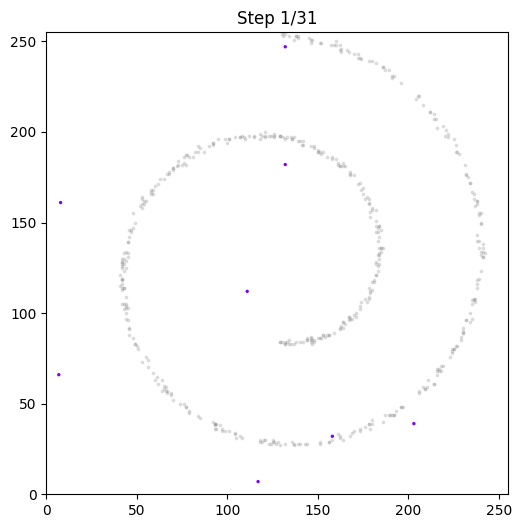

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection

# ▼ 描画準備
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_aspect('equal')
ax.set_title("Vertex Centers and Scores during Training")

# カラーマップ
colors = ["blue","green", "red"]
cmap = LinearSegmentedColormap.from_list("blue_green_red", colors)

# 背景の入力データ（灰色点）
ax.scatter(X[:,0], X[:,1], c='gray', s=3, alpha=0.2, label='Input Data')

#polygon = Polygon([[180, 0], [20, 100], [50, 10]], closed=True, facecolor='cyan', edgecolor='none',alpha=0.1)
#ax.add_patch(polygon)

# 頂点群（初期化）
scatter = ax.scatter([], [], s=[], c=[], cmap="rainbow", vmin=0, vmax=255)

# 頂点の反応半径（初期化）
r_scatter = ax.scatter([], [], s=[], facecolors='none', edgecolors='blue', linewidths=1, alpha=0.5)

# 線分群（初期化）
lines = LineCollection([], colors='black', linewidths=1, alpha=0.5)
ax.add_collection(lines)

# 軸サイズピクセル
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width_px = bbox.width * fig.dpi
dx = width_px / 255

# ▼ フレームごとの更新関数
def update(frame):
    log = net.train_log[frame]

    # 頂点
    centers = log[0]
    scatter.set_offsets(centers[:,:-2])

    score1 = centers[:,-2]
    score2 = centers[:,-1]
    scatter.set_array(score2)
    size = score1 / np.max([np.max(score1),128]) * 255
    scatter.set_sizes(size)

    # 反応半径
    s = ((255-score2) * dx)**2 * 2
    #r_scatter.set_offsets(centers[:,:-2])
    #r_scatter.set_sizes(s)

    # 線分
    if len(log) > 1:
        connect = log[1][:,0:2]
        if connect.size == 0: return
        segments = centers[connect,0:2]

        lines.set_segments(segments)
        w = log[1][:,-1] / 255 +  1  # 黒＋透明度
        lines.set_linewidth(w)

    ax.set_title(f"Step {frame+1}/{len(net.train_log)}")

    return scatter,

# ▼ アニメーション作成
ani = animation.FuncAnimation(fig, update, frames=len(net.train_log), interval=50, blit=False)

# ▼ Colab 上で表示
from IPython.display import HTML
HTML(ani.to_jshtml())


"\nlines = net.vertex.centers[net.simplex[0].connect]\n\n\n#一次元単体ノード\nscores = net.simplex[0].out\nfor l,s in zip(lines,scores):\n    plt.plot(l[:,0], l[:,1], c='red',linewidth=50/s)\n"

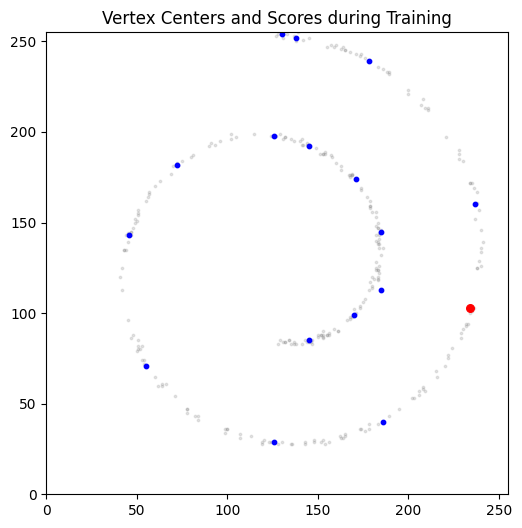

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection

######################################################################
# グラフ準備
######################################################################
# ▼ 描画準備
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_aspect('equal')
ax.set_title("Vertex Centers and Scores during Training")


# 背景の入力データ（灰色点）
ax.scatter(X[:,0], X[:,1], c='gray', s=3, alpha=0.2)

# 頂点ノード
ax.scatter(net.vertex.centers[:,0], net.vertex.centers[:,1], c='blue', s=10)


######################################################################
# テストデータを表示
######################################################################
x = X[207] #データを選択
y = net.forward(x) #推論

#データを赤く表示
ax.scatter(x[0], x[1], c='red', s=30, label='Input Data')

"""
lines = net.vertex.centers[net.simplex[0].connect]


#一次元単体ノード
scores = net.simplex[0].out
for l,s in zip(lines,scores):
    plt.plot(l[:,0], l[:,1], c='red',linewidth=50/s)
"""